Pseudotime Trajectory Inference
===============================

Infer pseudotime and lineage tree from nearest neighbors graph of multiome data.
Uses an adaptation of the Palantir algorithm to calculate diffusion
pseudotime and terminal state probabilities for each cell. Then, applies
MIRA's lineage tree inference algorithm to reconstruct bicurcating tree
structure of differentation data.

In this tutorial, we will use pseudotime trajectory inference to investigate
the lineage structure of the hair follicle.

First, import packages and the data:

In [1]:
import mira
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
from IPython.display import Image, display

umap_kwargs = dict(
    add_outline=True, outline_width=(0.1,0), outline_color=('grey', 'white'),
    legend_fontweight=550, frameon = False, legend_fontsize=12
)

data = anndata.read_h5ad('data/shareseq/hf_minimal.h5ad')

Taking a look at the UMAP, we see that starting from the **ORS**, cells progress through the **Matrix**, branching into the **IRS**, then the **Cortex** and **Medulla**.

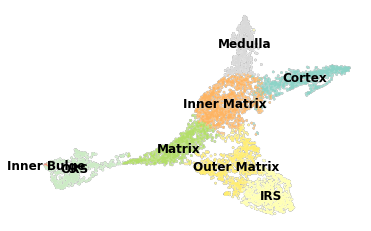

In [2]:
sc.pl.umap(data, color = 'true_cell', palette='Set3', legend_loc='on data', title = '',
          **umap_kwargs)

The first step in identifying the lineage structure of this data is to compute a diffusion map of the underlying nearest neighbors graph. ``sc.tl.diffmap`` will use the KNN graph in ``data.obsp["connectivities"]`` to compute a diffusion map representation of the data. In this case, the connectivities are derived from the Joint KNN graph, so the diffusion map will represent cells in a bimodal space.

First, calculate the diffusion map, then use [mira.time.normalize_diffmap](../time/mira.time.normalize_diffmap.html) to rescale the components of the diffusion map. This regularizes distortions in magnitude of the eigenvectors.

In [3]:
sc.tl.diffmap(data)
mira.time.normalize_diffmap(data)

INFO:root:Added key to obsm: X_diffmap, normalized diffmap with 14 components.
INFO:root:Added key to uns: eigen_gap


Recommending 5 diffusion map components.


Next, we need to choose the best number of diffusion components to represent the data. Too few components will not capture the full structure of the data, too many will overfit and induce strange structures. Below, we use [mira.pl.plot_eigengap](../time/mira.pl.plot_eigengap.html) to plot the "Eigengap" heuristic, which is the difference in magnitude of successive sorted eigenvalues. 


**The component with the highest Eigengap is an estimate of the best number of components to represent the data**, but may not capture all relevent structure. For this reason, we also plot the diffusion components projected over the UMAP, with which we can check how many components are needed to capture differences between cell types.

In the case of the hair follicle, Eigengap recommends using 5 diffusion components, which appears to adequately describe differences bewteen cell types.

/Users/alynch/projects/multiomics/mira/mira/mira/plots/eigengap_plot.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  ax[0].plot(range(len(eigvals)-1), eigvals[1:], '--bo', c = 'black')


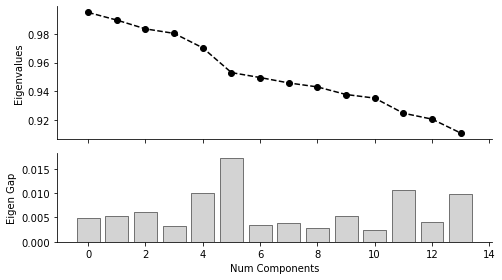

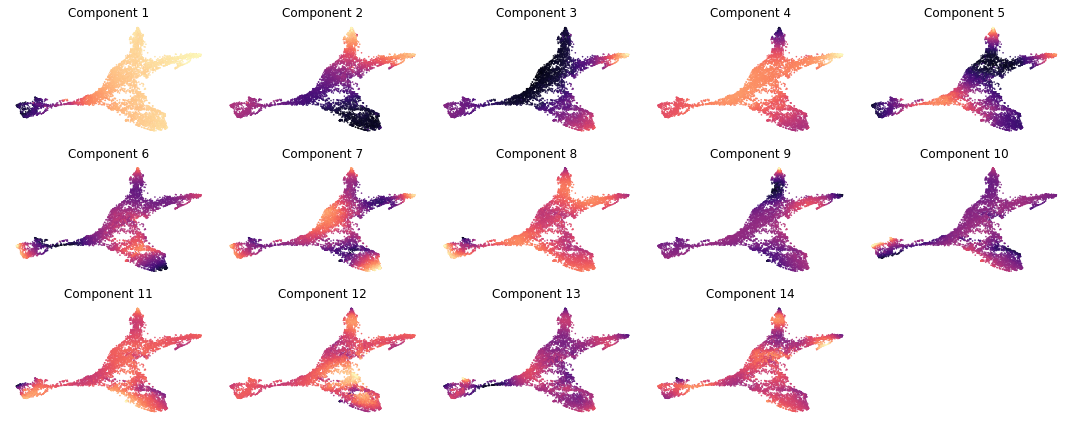

In [4]:
mira.pl.plot_eigengap(data, palette='magma')
plt.show()

Next, we must define a new nearest-neighbors graph based on the diffusion components. For `sc.pp.neighbors`, we indicate that we wish to calculate a new KNN graph using the first 5 components from `data.obsm["X_diffmap"]`.

**It is critical that you specify how many components (pcs) to use while calculating nearest neighbors on the diffusion map**.

In [5]:
sc.pp.neighbors(data, use_rep='X_diffmap', n_pcs = 5, key_added='X_diffmap', n_neighbors = 20)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Then, we check to make sure there are no disconnected component graphs in the data using [mira.time.get_connected_components](../time/mira.time.get_connected_components.html). The remainder of the methods only work on connected graphs, and will raise an error if they are run on cells spanning multiple disconnected components.

In [6]:
mira.time.get_connected_components(data)

INFO:mira.pseudotime.pseudotime:Found 1 components of KNN graph.
INFO:mira.adata_interface.core:Added cols to obs: mira_connected_components


Now, we can assign cells a pseudotime and define a transport map describing a markov chain model of forward differentiation using [mira.time.get_transport_map](../time/mira.time.get_transport_map.html). This function requires we define a start cell, which must be chosen using knowledge of the system. Usually, the cell which is the minima or maxima of the first diffusion component works well as a start point. In this case, we use the minima:

In [7]:
mira.time.get_transport_map(data, start_cell= int(data.obsm['X_diffmap'][:,0].argmin()),
                            n_jobs=4)

INFO:mira.pseudotime.pseudotime:Calculating inter-cell distances ...


Calculating pseudotime:   0%|          | 0/54725 [00:00<?, ?it/s]

INFO:mira.pseudotime.pseudotime:Calculating transport map ...
INFO:mira.adata_interface.pseudotime:Added key to obs: mira_pseudotime
INFO:mira.adata_interface.pseudotime:Added key to obsp: transport_map
INFO:mira.adata_interface.pseudotime:Added key to uns: start_cell


From the transport map, we may find terminal states where the markov chain reaches a steady state. [mira.time.find_terminal_cells](../time/mira.time.find_terminal_cells.html) outputs cells that appear to be at the termini of lineages.

INFO:mira.pseudotime.pseudotime:Found 5 terminal states from stationary distribution.


['R1.61.R2.10.R3.44.P1.56' 'R1.39.R2.56.R3.80.P1.54'
 'R1.41.R2.69.R3.40.P1.55' 'R1.41.R2.53.R3.46.P1.53'
 'R1.89.R2.32.R3.50.P1.54']


/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'mira_connected_components' as categorical


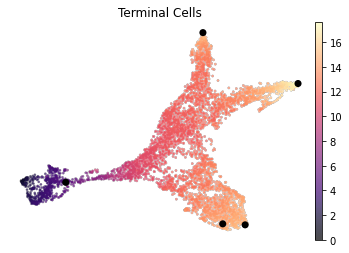

In [8]:
terminal_cells = mira.time.find_terminal_cells(data, iterations = 5)
print(terminal_cells)

ax = sc.pl.umap(data, color = 'mira_pseudotime', show = False,
           **umap_kwargs, color_map = 'magma')
sc.pl.umap(data[terminal_cells], na_color = 'black', ax = ax, 
           size = 200, title = 'Terminal Cells')

Next, we use [mira.time.get_branch_probabilities](../time/mira.time.get_branch_probabilities.html) to find the probability of reaching each terminal state from each cell in the markov chain. To this function, we provide a dictionary with lineage names as keys, and values as terminal cell barcodes.

In [9]:
mira.time.get_branch_probabilities(data, terminal_cells= {
    'Medulla' : 'R1.61.R2.10.R3.44.P1.56',
    'Cortex' : 'R1.41.R2.69.R3.40.P1.55',
    'IRS' : 'R1.41.R2.53.R3.46.P1.53',
})

INFO:mira.pseudotime.pseudotime:Simulating random walks ...
INFO:mira.adata_interface.pseudotime:Added key to obsm: branch_probs
INFO:mira.adata_interface.pseudotime:Added key to uns: lineage_names
INFO:mira.adata_interface.core:Added cols to obs: Medulla_prob
INFO:mira.adata_interface.core:Added cols to obs: Cortex_prob
INFO:mira.adata_interface.core:Added cols to obs: IRS_prob
INFO:mira.adata_interface.core:Added cols to obs: differentiation_entropy


Outputs from this function include the probabilities of reaching each terminal state, and differentiation entropy.

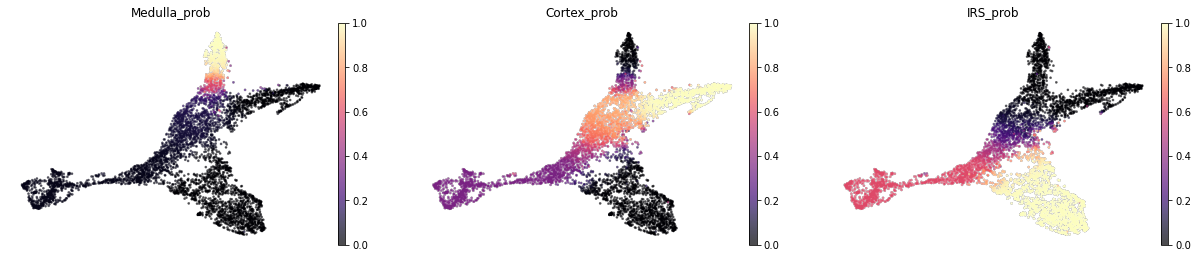

In [10]:
sc.pl.umap(data,
   color = [x + '_prob' for x in data.uns['lineage_names']], 
   color_map='magma', **umap_kwargs)

Finally, we can parse the lineage probabilities to find the bifurcating tree structure of the data. The [mira.time.get_tree_structure](../time/mira.time.get_tree_structure.html) function takes the *threshold* parameter, which controls how sensitive the algorithm is to branch divergences. 

INFO:mira.adata_interface.pseudotime:Added key to obs: tree_states
INFO:mira.adata_interface.pseudotime:Added key to uns: tree_state_names
INFO:mira.adata_interface.pseudotime:Added key to uns: connectivities_tree
/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tree_states' as categorical


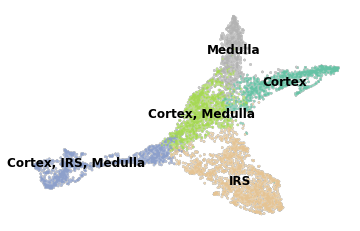

In [11]:
mira.time.get_tree_structure(data, threshold = 1)
sc.pl.umap(data, color = 'tree_states', palette = 'Set2', 
           **umap_kwargs, title = '', legend_loc='on data')

Finally, with the tree structure solved, we can visualize expression dynamics using streamgraphs. For more information on making informative visualizations using this flexible interface, read the [streamgraph docs](../plotting/mira.pl.plot_stream.html).

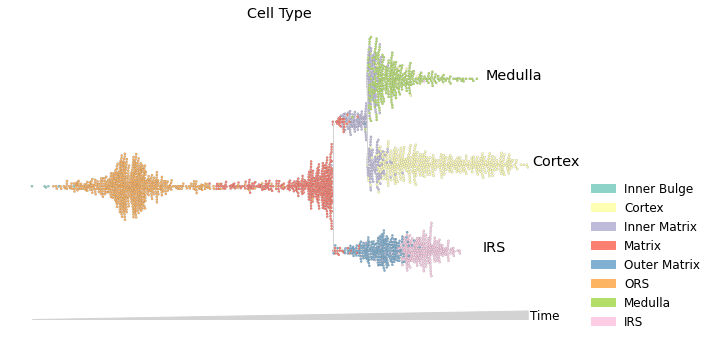

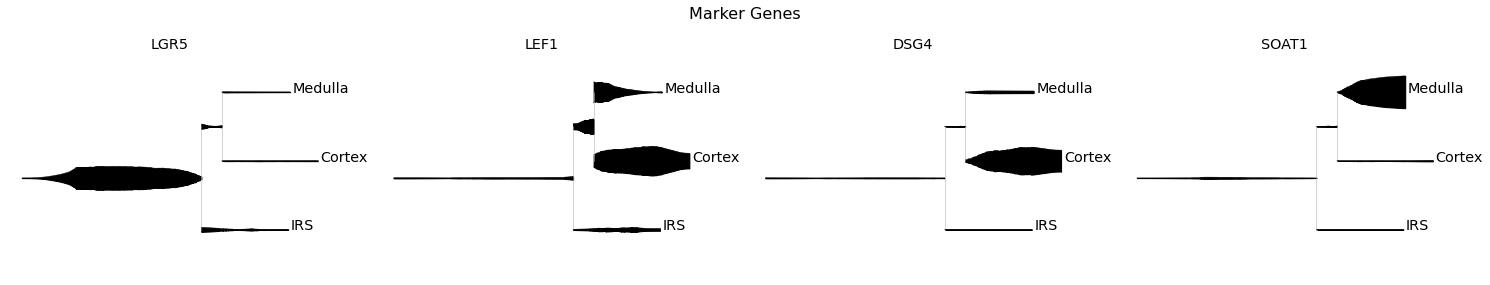

In [12]:
data.obs.true_cell = data.obs.true_cell.astype(str)
mira.pl.plot_stream(data, data = 'true_cell', log_pseudotime=False, max_bar_height=0.99, title = 'Cell Type',
                    figsize=(10,5), style = 'swarm', palette='Set3', size = 5, max_swarm_density = 100)


mira.pl.plot_stream(data, data = ['LGR5','LEF1','DSG4','SOAT1'], 
    log_pseudotime=False, layers = 'normalized',
    clip = 3, window_size=301, scale_features=True, max_bar_height=0.8, hide_feature_threshold=0.03,
    linewidth=0.5, figsize=(7,4), order = None, split = True, pseudotime_triangle=False, 
    title = 'Marker Genes')
plt.show()

We can also simulate the differentiation process using [mira.time.trace_differentiation](../time/mira.time.trace_differentiation.html). In this case, we may be interested in finding the ancestral populations of the **IRS** lineage.

This function traces the differentiation process through the diffusion map starting from user-defined start cells, and may be used to investigate complicated lineage structures that may violate the typical assumptions made during lineage inference (no cycles, one path to each termini, terminal states don't regress, etc.)

We can start from a given ``start_lineage`` and work backwards, like below:

INFO:mira.pseudotime.backtrace:Creating transport map ...
INFO:mira.pseudotime.backtrace:Tracing ancestral populations ...


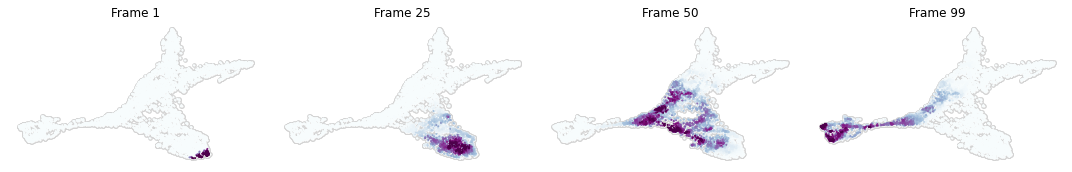

INFO:mira.pseudotime.backtrace:Creating animation ...
INFO:mira.pseudotime.backtrace:Saving animation ...
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


In [13]:
mira.time.trace_differentiation(data, start_lineage='IRS', num_steps=1500,
                               save_name='data/hf_diff.gif', direction='backward', sqrt_time=True,
                               log_prob=True, steps_per_frame=15, figsize=(7,4))

The function above makes a video of the process and prints out some preview frames. Then, it saves the video to ``save_name`` as a gif.

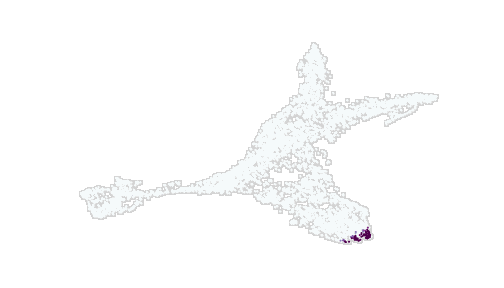

In [14]:
with open('data/hf_diff.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

We may also run a forward simulation from an interesting group of cells to see their ancestral populations. In this case, we may want to see if the **SSH+ matrix** population can still generate the **IRS** population:

/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'true_cell' as categorical


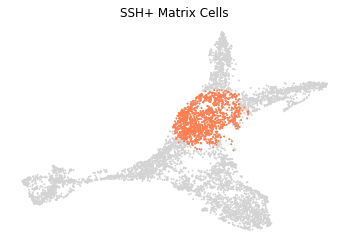

In [15]:
ax = sc.pl.umap(data, show = False, size = 15)
sc.pl.umap(data[data.obs.true_cell == 'Inner Matrix'], na_color = 'coral', ax = ax,
          frameon=False, size = 15, title = 'SSH+ Matrix Cells')

INFO:mira.pseudotime.backtrace:Creating transport map ...
/Users/alynch/projects/multiomics/mira/mira/mira/pseudotime/pseudotime.py:289: RuntimeWarning: divide by zero encountered in true_divide
  inverse_rowsums = sparse.diags(1/np.array(affinity_matrix.sum(axis = 1)).reshape(-1)).tocsr()
INFO:mira.pseudotime.backtrace:Tracing ancestral populations ...


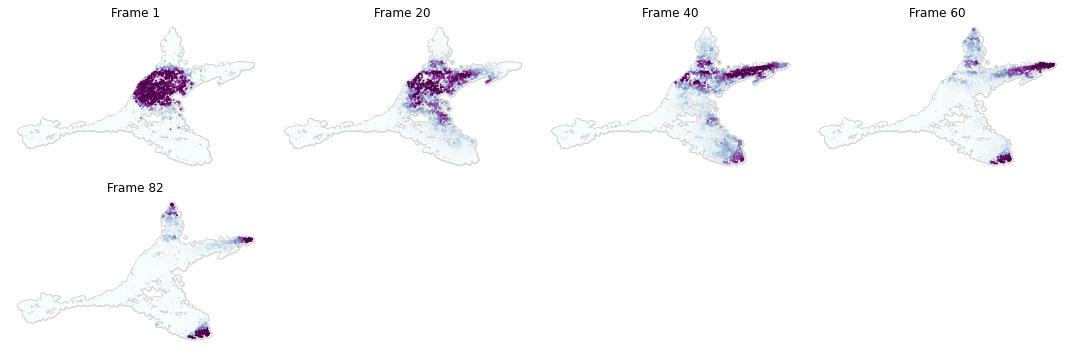

INFO:mira.pseudotime.backtrace:Creating animation ...
INFO:mira.pseudotime.backtrace:Saving animation ...
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


In [ ]:
mira.time.trace_differentiation(data,start_cells=data.obs.true_cell.values == 'Inner Matrix', num_steps=1001,
                               save_name='data/hf_diff.gif', direction='forward', sqrt_time=True,
                               log_prob=True, steps_per_frame=12, figsize=(7,4), ka = 2,
                               vmax_quantile=0.97)

In [ ]:
with open('data/hf_diff.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

Yes! This consistent with experimental lineage tracing evidence that **SSH+ matrix** cells can differentiate into **IRS** cells. This also suggests that the pathway from **SSH-** and **SSH+ matrix** cells to the **IRS** cell type is distinct.